Will they be an all-star? -> Binary Classification

Data Considerations:

*   Class Imbalance Present
    *   Oversampling - create copies of all-star data based on quantile
    *   Undersampling - remove instances based on all-star data min,max,avg, quantile (we want data similar to all-star data so model can differentiate between the two)

ML Technique: **Random Forest**

Performance Metrics:


*   Confusion Matrix
*   AUC
*   Precision/Recall and F1 Score
*   ROC Curve

**NEXT STEPS:**

*   Use additional ML techniques and compare through performance metrics
*   Make adjustments through validation data?






In [65]:
import pandas as pd
fullData = pd.read_csv("all_seasons_w_all_star.csv")

#look at all columns (features)
fullData.head()

,Unnamed: 0,Unnamed: 0.1,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,all_star
0,0,0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986,2,27,55,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97,0.0
1,1,1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,24,15,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97,0.0
2,2,2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,58,9,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97,0.0
3,3,3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,9,64,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97,0.0
4,4,4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,10,27,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97,0.0


In [66]:
#look at just all-star data to determine conditions for non-all star data (undersampling) as well as ranges quantiles (oversampling)
aSData = fullData.loc[fullData['all_star'] == 1.0]

Net Rating Avg: 5.1447098976109205
Net Rating Min :-14.3
0.010   -6.272
0.025   -4.940
0.050   -2.540
0.100   -1.200
0.250    1.700
0.750    8.800
Name: net_rating, dtype: float64


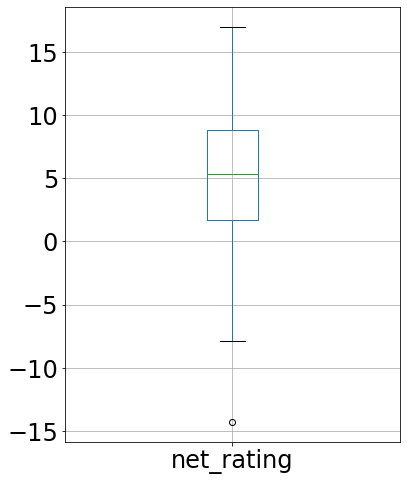

In [67]:
#Net Rating
meanNR= aSData['net_rating'].mean()
minNR = aSData['net_rating'].min()
distNR = aSData['net_rating'].quantile([0.01, 0.025, 0.05, 0.1, 0.25,.75])

print('Net Rating Avg: ' + str(meanNR))
print('Net Rating Min :' + str(minNR))
print(distNR)
aSData.boxplot(column='net_rating',figsize=(6,8),fontsize=24)

GP Avg: 72.19795221843003
GP Min : 5
0.010    36.48
0.025    42.60
0.050    50.60
0.100    55.00
0.150    61.00
0.200    66.00
0.250    68.00
Name: gp, dtype: float64


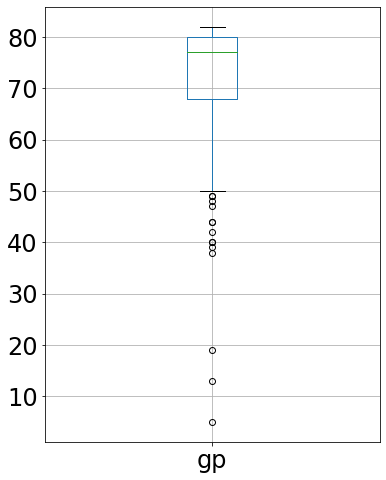

In [68]:
#Games Played
meanGP = aSData['gp'].mean()
minGP = aSData['gp'].min()
distGP = aSData['gp'].quantile([0.01, 0.025, 0.05, 0.1, .15, .2, 0.25])

print('GP Avg: ' + str(meanGP))
print('GP Min : ' + str(minGP))
print(distGP)
aSData.boxplot(column='gp',figsize=(6,8),fontsize=24)

UR Avg: 0.26020477815699666
UR Min : 0.10300000000000001
0.10    0.2092
0.15    0.2170
0.20    0.2274
0.25    0.2340
0.50    0.2620
0.75    0.2900
Name: usg_pct, dtype: float64


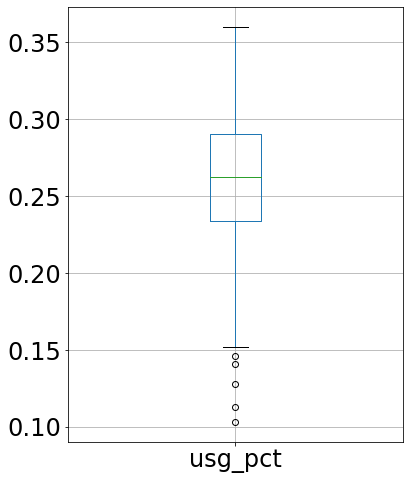

In [69]:
#Usage Rate (Percentage)
meanUR = aSData['usg_pct'].mean()
minUR = aSData['usg_pct'].min()
distUR = aSData['usg_pct'].quantile([.1,.15,.2,.25,.5,.75])

print('UR Avg: ' + str(meanUR))
print('UR Min : ' + str(minUR))
print(distUR)
aSData.boxplot(column='usg_pct',figsize=(6,8),fontsize=24)

In [70]:
#Looking at non-all star for undersampling

nSData = fullData.loc[fullData['all_star'] == 0.0]

distNSGP = nSData['gp'].quantile([.1,.25,.5,.75])
distNSNR = nSData['net_rating'].quantile([0.05, 0.125, 0.25, 0.5, .75])
distNSUR = nSData['usg_pct'].quantile([0.05, 0.125, 0.25, 0.5, .75])

print(distNSGP)
print(distNSNR)
print(distNSUR)

0.10    11.0
0.25    31.0
0.50    57.0
0.75    74.0
Name: gp, dtype: float64
0.050   -17.2
0.125   -10.6
0.250    -6.5
0.500    -1.5
0.750     3.0
Name: net_rating, dtype: float64
0.050    0.107
0.125    0.129
0.250    0.149
0.500    0.181
0.750    0.215
Name: usg_pct, dtype: float64


In [71]:
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import math
import string
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import json
import gzip
from urllib.request import urlopen

In [72]:
#locate based on conditions then just append
aSData = fullData.loc[fullData['all_star'] == 1.0]

#All Star data standard quantiles
minGP, maxGP = float(aSData['gp'].quantile([0.25])), float(aSData['gp'].quantile([0.75]))
minNR, maxNR = float(aSData['net_rating'].quantile([0.25])), float(aSData['net_rating'].quantile([0.75]))
minUR, maxUR = float(aSData['usg_pct'].quantile([0.25])), float(aSData['usg_pct'].quantile([0.75]))

#acquire rows that are within range for games played, net rating, and usage rate
aSDataGPQ = aSData.loc[(aSData['gp'] >= minGP) & (aSData['gp'] <= maxGP)]
aSDataNRQ = aSData.loc[(aSData['net_rating'] >= 1.7) & (aSData['net_rating'] <= 8.8)]
aSDataURQ = aSData.loc[(aSData['usg_pct'] >= .234) & (aSData['usg_pct'] <= .290)]

#acquire all all-star data and non-all-star data that meets conditions based on earlier observations
rawData = fullData.loc[((fullData['all_star'] == 0.0) & (fullData['gp'] > 55) & (fullData['net_rating'] > 1) & (fullData['usg_pct'] > .19)) | (fullData['all_star'] == 1.0)]

frames = [aSDataGPQ, aSDataNRQ, aSDataURQ, rawData]

#combine all dataframes
testData = pd.concat(frames)

#perform class majority classifer
train_data, test_data = train_test_split(testData, test_size = 0.2, random_state = 1)

acc = "{:.2%}".format((test_data['all_star']>0).sum()/len(test_data['all_star']))
print('Majority Classifier : ' + acc)

#remove features we are not interested in using in the model
features = list(train_data.columns)

removing = ['Unnamed: 0', 'Unnamed: 0.1', 'player_name', 'team_abbreviation', 'age', 'player_height', 'player_weight', 'college', 'country', 'draft_year', 'draft_round', 'draft_number', 'season', 'all_star']

for i in range(len(removing)):
    features.remove(removing[i])

Majority Classifier : 42.19%


In [73]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
#Random Forest

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 1)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=1)

# Fit
rs.fit(train_data[features], train_data['all_star'])

print(rs.best_params_)
best_model = rs.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.1s finished


{'n_estimators': 106, 'min_samples_split': 2, 'max_leaf_nodes': 46, 'max_features': 0.8999999999999999, 'max_depth': 15, 'bootstrap': True}


In [74]:
#Confusion Matrix Function
def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg'])

Accuracy Score : 90.14%
Precision : 85.98%
Recall : 91.56%
F1 Score : 88.68%


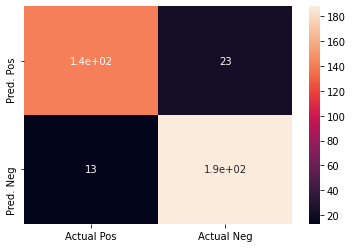

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

rf_pred = best_model.predict(test_data[features])

test = test_data['all_star'].values

tn, fp, fn, tp = (confusion_matrix(test,rf_pred).ravel())

plot_confusion_matrix(tp, fp, fn, tn)

accScore = "{:.2%}".format(accuracy_score(test,rf_pred))

print('Accuracy Score : ' + accScore)

#Precision and Recall
precision = (tp/(tp+fp))
recall = (tp/(tp+fn))
F1Score = (2*precision*recall)/(precision+recall)

print('Precision : ' + "{:.2%}".format(precision))
print('Recall : ' + "{:.2%}".format(recall))
print('F1 Score : ' + "{:.2%}".format(F1Score))

In [76]:
#AUC
from sklearn.metrics import roc_auc_score

rf_probs = best_model.predict_proba(test_data[features])
rf_probs = rf_probs[:,1]
rf_auc = roc_auc_score(test_data['all_star'], rf_probs)
print(rf_auc)

0.9552840524404506


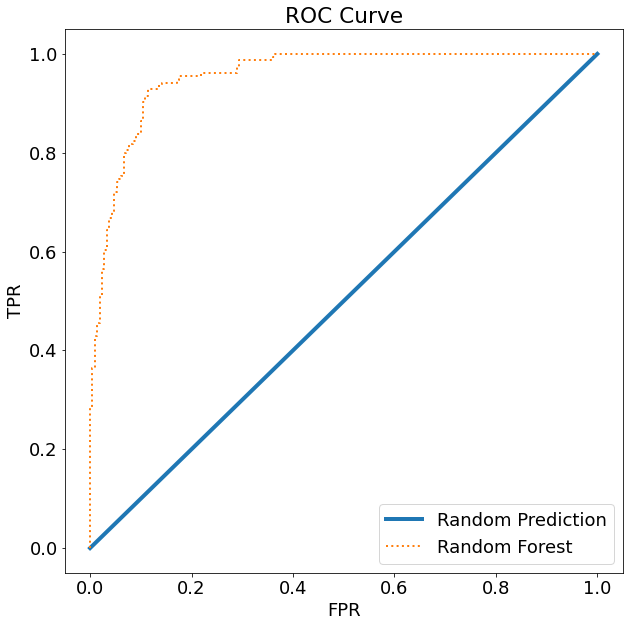

In [78]:
#ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

r_probs = [0 for _ in range (len(test_data['all_star']))]

r_fpr, r_tpr, _ = roc_curve(test_data['all_star'], r_probs)
rf_fpr, rf_tpr, _ = roc_curve(test_data['all_star'], rf_probs)

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})

plt.plot(r_fpr,r_tpr,linewidth = 4, label = 'Random Prediction')
plt.plot(rf_fpr, rf_tpr,linewidth = 2,linestyle=':', label = 'Random Forest')

plt.title('ROC Curve')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.show()